In [1]:
from __future__ import print_function

# ignore some Keras warnings regarding deprecations and model saving 
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
import pickle

from helpers import *
import importlib
from importlib import reload

Using TensorFlow backend.


Sentences from the [tatoeba dataset](https://tatoeba.org/eng/downloads)

In [2]:
batch_size = 128  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =200000 # Number of samples to train on.
# Path to the datatxt file on disk.
data_path = 'sentences.txt'

epochs = 100
noise = 0.05
misspellings_count = 3
chunk_size = 40000

optimizer='rmsprop'
loss_fn='categorical_crossentropy'


In [3]:
# Hand-pick maximum sequence lengths
max_encoder_seq_length = 25
max_decoder_seq_length = 30

In [4]:
def load_preprocessed(data_path):
    with open(data_path) as f:
        lines = f.readlines()
    lines = text_preprocess(lines)
    # allow only for a limited count of 
    allowed_chars = {'.', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', 
             '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', 
             '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 
             '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 
             'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
             's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}' }
    selected = []
    for l in lines:
        if all([c in allowed_chars for c in l.strip()]) and \
           len(l) < max_encoder_seq_length:
            selected.append(l)
    # suffle deterministically
    Random(0).shuffle(selected)
    return selected

In [5]:
all_phrases = load_preprocessed(data_path)
input_phrases = all_phrases[:num_samples]
test_phrases = all_phrases[num_samples:]
print('All phrases in dataset: ', len(all_phrases))
print('Training phrases: ', len(input_phrases))
print('Test phrases: ', len(test_phrases))

print("\n * ".join(['Examples:'] + all_phrases[:10]))

All phrases in dataset:  210139
Training phrases:  200000
Test phrases:  10139
Examples:
 * leave him alone, please
 * what do you call love?
 * tom got in the taxi
 * we can trust tom
 * i'd like you to meet tom
 * the money is terrible
 * did you go to see him?
 * monday will be a hot day
 * tom took mary to dinner
 * turn on the light please


In [6]:
# create doken indices out of all phrases
input_token_index = token_index(all_phrases)
num_encoder_tokens = len(input_token_index)
target_token_index = {'\t': num_encoder_tokens, 
                      '\n': num_encoder_tokens+1, 
                      **input_token_index}
num_decoder_tokens = len(target_token_index)

# Keep the count of all the possible input characters

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 55
Number of unique output tokens: 57


In [7]:
def models(num_encoder_tokens, num_decoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_inputs')
    encoder = LSTM(latent_dim, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', 
                          name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Next: inference mode (sampling).
    # Here's the drill:
    # 1) encode input and retrieve initial decoder state
    # 2) run one step of decoder with this initial state
    # and a "start of sequence" token as target.
    # Output will be the next target token
    # 3) Repeat with the current target token and current states

    # Define sampling models
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_input_h')
    decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_input_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model


In [8]:
model, encoder_model, decoder_model = models(num_encoder_tokens, num_decoder_tokens, latent_dim)

model.compile(optimizer=optimizer, loss=loss_fn)

Train few epochs on an identity fn with a chunk of the dataset for sanity

In [9]:
train_input_phrases = input_phrases[:10000]
X, Y = vectorize_dataset(train_input_phrases, wrap_with_delims(train_input_phrases),
                  input_token_index,target_token_index,
                  max_encoder_seq_length, max_decoder_seq_length)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 11s 1ms/step - loss: 2.0213 - val_loss: 1.8918
Epoch 2/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.8122 - val_loss: 1.7021
Epoch 3/100
9000/9000 [==============================] - 11s 1ms/step - loss: 1.6367 - val_loss: 1.5576
Epoch 4/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.5195 - val_loss: 1.5098
Epoch 5/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.4479 - val_loss: 1.4396
Epoch 6/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.3899 - val_loss: 1.3576
Epoch 7/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.3278 - val_loss: 1.3101
Epoch 8/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.2753 - val_loss: 1.2714
Epoch 9/100
9000/9000 [==============================] - 10s 1ms/step - loss: 1.2376 - val_loss: 1.2211
Epoch 10/100
900

9000/9000 [==============================] - 9s 1ms/step - loss: 0.2775 - val_loss: 0.7592
Epoch 79/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2695 - val_loss: 0.7784
Epoch 80/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2623 - val_loss: 0.7700
Epoch 81/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2537 - val_loss: 0.7770
Epoch 82/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2477 - val_loss: 0.7615
Epoch 83/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2402 - val_loss: 0.7859
Epoch 84/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2360 - val_loss: 0.7721
Epoch 85/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2269 - val_loss: 0.8024
Epoch 86/100
9000/9000 [==============================] - 9s 1ms/step - loss: 0.2214 - val_loss: 0.7805
Epoch 87/100
9000/9000 [==============================] - 9s 1ms/step - loss:

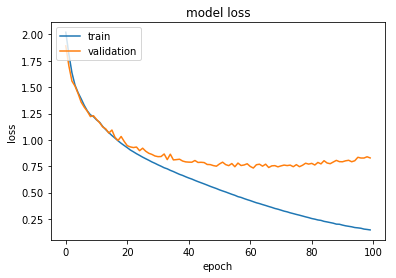

In [10]:
history = model.fit(X,Y,
                   batch_size=batch_size, epochs=100, 
                   validation_split=0.1)
plot_history(history)

Create a "corrector" fn that will "translate" our misspelled input to a right one

In [11]:
corrector = translate_fn(encoder_model, decoder_model, 
                         input_token_index, target_token_index,
                        max_encoder_seq_length)

In [12]:
# let's see what our model has learned so far
# by trying to "correct" some correct phrases
[corrector(p) for p in train_input_phrases[:10]]

['leave help mary for me!',
 'what do you call love?',
 'tom got in the bair',
 "we can't stopting",
 "i'd like you to do this",
 'the money is need you',
 'did you thing to you?',
 'monday is wearing childed',
 'tom told me be on my wir',
 'turn on the lights leath']

In [13]:
def evaluate_correct(texts, corrector):
    errors = 0.0
    for t in texts:
        if t != corrector(t): errors += 1
    return errors / len(texts)

def evaluate_misspelled(texts, corrector):
    errors = 0.0
    for t in texts:
        errored = add_noise_to_string(t, 0.05)
        if t != corrector(errored): errors += 1
    return errors / len(texts)

In [14]:
evaluate_correct(train_input_phrases[:100], corrector)

0.79

In [15]:
evaluate_misspelled(train_input_phrases[:100], corrector)

0.87

In [16]:
def training_vectorizer_fn(input_token_index, max_encoder_seq_length,
                           target_token_index, max_decoder_seq_length):
    # create a closure fn that "knows" the token indices and seq lengths
    def training_vectorizer(input_texts, target_texts):
        encoder_input_data = vectorize_batch(input_texts, input_token_index,
                                             max_encoder_seq_length)
        decoder_input_data = vectorize_batch(target_texts, target_token_index,
                                             max_decoder_seq_length)
                # same as decoder input data, but offset by one
        decoder_output_data = vectorize_batch(target_texts, target_token_index,
                                              max_decoder_seq_length, True)
        X = [encoder_input_data, decoder_input_data]
        Y = decoder_output_data
        return X, Y

    return training_vectorizer

# Create a training_vectorizer that only accepts input and target texts
training_vectorizer = training_vectorizer_fn(input_token_index, max_encoder_seq_length,
                                             target_token_index, max_decoder_seq_length)

In [17]:
def batched_gen(phrases, batch_size, misspellings_count, noise):
    """Goes through the given phrases, in `batch_size` batches, generating 
    `misspellings_count` misspelling allongside them.
    On each iteration it yields `batch_size`* (1+ misspellings_count) strings: 
    the original strings and the misspellings generated out of them"""
    for i in range(0, len(phrases), batch_size):
        frrom = i
        to = i+batch_size
        print("Yielding phrases from #%d to #%d" % (frrom, to))
        yield create_misspellings(phrases[frrom:to], noise, misspellings_count)

In [18]:
tst = batched_gen(input_phrases, 3, 2, 0.07)
inp, trgt = next(tst)
for i,t in zip(inp, trgt):
    print(i, '->',t)

Yielding phrases from #0 to #3
leave him alone, please -> leave him alone, please
what do you call love? -> what do you call love?
tom got in the taxi -> tom got in the taxi
leae him alone, pelase -> leave him alone, please
what edo you call love? -> what do you call love?
tom got int h taxi -> tom got in the taxi
leave him alonec please -> leave him alone, please
wat do yuo call love? -> what do you call love?
tom got in the taxi -> tom got in the taxi


In [19]:
def vectorized_gen(phrases, batch_size, misspellings_count, noise,
                   training_vectorizer):
    """Creates vextorized batches of phrases (that are wrapped with delims)"""
    # Create a generator of misspelled strings from the input phrases
    gen = batched_gen(phrases, batch_size, misspellings_count, noise)
    
    # Go through all the input phrases, generatiing misspellings, vectorizing them
    # and yielding each batch
    for input_phrases, target_phrases in gen:
        target_phrases = wrap_with_delims(target_phrases)
        X, Y = training_vectorizer(input_phrases, target_phrases)
        # Yield the data in a X, Y form
        yield (X, Y)

In [ ]:
# create a final generator holding all the context
def training_generator():
    gen = vectorized_gen(input_phrases, chunk_size,
                         misspellings_count, noise,
                         training_vectorizer)
    yield from gen

In [ ]:
for epoch in range(epochs):
    print("(Real) Epoch: %s" % epoch)
    # Initialize the generator
    gen = training_generator()
    for X, Y in gen:
        model.fit(X, Y,
              batch_size=batch_size,epochs=1, validation_split=0.1)
        print('Test Error:', evaluate_misspelled(test_phrases[:200], corrector))


(Real) Epoch: 0
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 149s 1ms/step - loss: 0.4854 - val_loss: 0.4298
Test Error: 0.975
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 151s 1ms/step - loss: 0.3487 - val_loss: 0.3132
Test Error: 0.9
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 156s 1ms/step - loss: 0.2604 - val_loss: 0.2393
Test Error: 0.84
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 156s 1ms/step - loss: 0.2021 - val_loss: 0.1861
Test Error: 0.73
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [============

144000/144000 [==============================] - 170s 1ms/step - loss: 0.0469 - val_loss: 0.0561
Test Error: 0.325
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 174s 1ms/step - loss: 0.0455 - val_loss: 0.0558
Test Error: 0.355
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 170s 1ms/step - loss: 0.0460 - val_loss: 0.0555
Test Error: 0.395
(Real) Epoch: 8
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 180s 1ms/step - loss: 0.0453 - val_loss: 0.0541
Test Error: 0.345
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 189s 1ms/step - loss: 0.0448 - val_loss: 0.0540
Test Error: 0.365
Yielding 

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 151s 1ms/step - loss: 0.0357 - val_loss: 0.0466
Test Error: 0.32
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 152s 1ms/step - loss: 0.0356 - val_loss: 0.0454
Test Error: 0.3
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 152s 1ms/step - loss: 0.0354 - val_loss: 0.0445
Test Error: 0.32
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 152s 1ms/step - loss: 0.0350 - val_loss: 0.0443
Test Error: 0.275
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0352 

Test Error: 0.28
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 177s 1ms/step - loss: 0.0310 - val_loss: 0.0387
Test Error: 0.305
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 181s 1ms/step - loss: 0.0312 - val_loss: 0.0403
Test Error: 0.315
(Real) Epoch: 23
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 182s 1ms/step - loss: 0.0313 - val_loss: 0.0401
Test Error: 0.28
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 182s 1ms/step - loss: 0.0307 - val_loss: 0.0403
Test Error: 0.34
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/

144000/144000 [==============================] - 154s 1ms/step - loss: 0.0288 - val_loss: 0.0373
Test Error: 0.235
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0286 - val_loss: 0.0370
Test Error: 0.34
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 157s 1ms/step - loss: 0.0289 - val_loss: 0.0370
Test Error: 0.305
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 157s 1ms/step - loss: 0.0286 - val_loss: 0.0361
Test Error: 0.32
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 158s 1ms/step - loss: 0.0286 - val_loss: 0.0370
Test Error: 0.265
(Real) Epoch: 31
Yield

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0271 - val_loss: 0.0342
Test Error: 0.28
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0273 - val_loss: 0.0346
Test Error: 0.225
(Real) Epoch: 38
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 181s 1ms/step - loss: 0.0275 - val_loss: 0.0351
Test Error: 0.295
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 191s 1ms/step - loss: 0.0270 - val_loss: 0.0343
Test Error: 0.235
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 194s 1ms/step -

144000/144000 [==============================] - 157s 1ms/step - loss: 0.0259 - val_loss: 0.0349
Test Error: 0.285
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 177s 1ms/step - loss: 0.0258 - val_loss: 0.0341
Test Error: 0.225
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 181s 1ms/step - loss: 0.0260 - val_loss: 0.0339
Test Error: 0.295
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 181s 1ms/step - loss: 0.0259 - val_loss: 0.0323
Test Error: 0.27
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 170s 1ms/step - loss: 0.0258 - val_loss: 0.0339
Test Error: 0.25
(Real) Epoch: 46
Yield

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 158s 1ms/step - loss: 0.0249 - val_loss: 0.0328
Test Error: 0.215
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 178s 1ms/step - loss: 0.0252 - val_loss: 0.0327
Test Error: 0.205
(Real) Epoch: 53
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 184s 1ms/step - loss: 0.0253 - val_loss: 0.0323
Test Error: 0.245
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 182s 1ms/step - loss: 0.0248 - val_loss: 0.0330
Test Error: 0.235
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 187s 1ms/step 

144000/144000 [==============================] - 160s 1ms/step - loss: 0.0241 - val_loss: 0.0317
Test Error: 0.195
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 161s 1ms/step - loss: 0.0241 - val_loss: 0.0317
Test Error: 0.25
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 162s 1ms/step - loss: 0.0246 - val_loss: 0.0309
Test Error: 0.24
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 161s 1ms/step - loss: 0.0242 - val_loss: 0.0299
Test Error: 0.28
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 161s 1ms/step - loss: 0.0243 - val_loss: 0.0313
Test Error: 0.245
(Real) Epoch: 61
Yieldi

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0236 - val_loss: 0.0306
Test Error: 0.22
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 160s 1ms/step - loss: 0.0237 - val_loss: 0.0310
Test Error: 0.25
(Real) Epoch: 68
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 151s 1ms/step - loss: 0.0239 - val_loss: 0.0308
Test Error: 0.2
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 151s 1ms/step - loss: 0.0237 - val_loss: 0.0315
Test Error: 0.31
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 151s 1ms/step - los

144000/144000 [==============================] - 178s 1ms/step - loss: 0.0230 - val_loss: 0.0313
Test Error: 0.215
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0233 - val_loss: 0.0307
Test Error: 0.295
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 168s 1ms/step - loss: 0.0230 - val_loss: 0.0305
Test Error: 0.275
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 156s 1ms/step - loss: 0.0231 - val_loss: 0.0301
Test Error: 0.25
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 157s 1ms/step - loss: 0.0232 - val_loss: 0.0300
Test Error: 0.21
(Real) Epoch: 76
Yield

In [ ]:
evaluate_correct(input_phrases[:1000], translator)

In [ ]:
evaluate_correct(input_phrases[-1000:], translator)

In [ ]:
evaluate_correct(test_phrases[:1000], translator)

In [ ]:
evaluate_correct(test_phrases[:1000], translator)

In [ ]:
def evaluate_vect(input_texts, target_texts, model, training_vectorizer):
    target_texts = wrap_with_delims(target_texts)
    
    #wrapped_target_texts = wrap_with_delims(target_texts)
    X, Y = training_vectorizer(input_texts, target_texts)
    loss = model.evaluate(X, Y)
    print('\nTesting loss: ', loss)


In [ ]:
evaluate_vect(input_phrases[:1000], input_phrases[:1000], model, training_vectorizer)

In [11]:
len(input_token_index)

60

In [23]:
# find max encoder seq legth
#max_encoder_seq_length = encoder_model.get_layer('encoder_inputs').input_shape[-1]
phrases = ['fire', 'stp', 'comein', 'get ot', 'i cant go','im sorry', 
           'h is busi', 'hes drunk', 'ill be lat', 'hold mi beer', 'pus the buton', 
          'coll me on my phone', 'helo boys and girls']

[translator(phrase) for phrase in phrases]

['\tfrier\n',
 '\tstep\n',
 '\tcome in\n',
 '\tget ot\n',
 "\ti can't go\n",
 "\ti'm sorry\n",
 '\the is busi\n',
 "\the's drunk\n",
 "\ti'll be late\n",
 '\thold my beer\n',
 '\tput the butzn\n',
 '\tcoll me on my phone\n',
 '\thello boys and girls\n']

In [17]:
test_phrases = all_phrases[20:1020]
misspelled_test_phrases = [add_noise_to_string(p, .1) for p in test_phrases]

pairs = zip(misspelled_test_phrases, test_phrases)
errors = list(filter(lambda p: cor(p[0]) != p[1], pairs))
len(errors)/float(len(test_phrases))

NameError: name 'translator' is not defined

In [ ]:
def save():
    """quick-n-dirty helper for saving models"""
    print("Saving model")
    model.save('training.h5')
    encoder_model.save('encoder.h5')
    decoder_model.save('decoder.h5')

    model_metadata = { 'input_token_index': input_token_index, 
                       'target_token_index': target_token_index,
                       'max_encoder_seq_length': max_encoder_seq_length }

    with open('model_metadata.pickle', 'wb') as f:
        pickle.dump(model_metadata, f)

In [39]:
input_phrases[0:10]

["i sure hope that tom doesn't sing",
 'i thought tom and mary were supposed to be here yesterday',
 "i've been living in a cave",
 'the child is learning quickly',
 'she turned off the lights so she could enjoy the moonlight',
 'tom asked me not to do that anymore',
 'tom had an allergic reaction to the medication',
 'he was shorter than me',
 "i didn't tell tom who told me that he'd stolen my saxophone",
 "there's no cause for concern"]